In [2]:
# Импортируем необходимые библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report

---

## Загрузка данных

In [3]:
churn_df = pd.read_csv('../datasets/customer_churn_data.csv')

In [4]:
churn_df.head()

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,NaN,2208.32,No,Yes


## EDA

In [5]:
churn_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   int64  
 1   Age              1000 non-null   int64  
 2   Gender           1000 non-null   object 
 3   Tenure           1000 non-null   int64  
 4   MonthlyCharges   1000 non-null   float64
 5   ContractType     1000 non-null   object 
 6   InternetService  703 non-null    object 
 7   TotalCharges     1000 non-null   float64
 8   TechSupport      1000 non-null   object 
 9   Churn            1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.2+ KB


In [6]:
churn_df.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
MonthlyCharges       0
ContractType         0
InternetService    297
TotalCharges         0
TechSupport          0
Churn                0
dtype: int64

In [7]:
churn_df["InternetService"].value_counts()

InternetService
Fiber Optic    395
DSL            308
Name: count, dtype: int64

Видно, что есть 207 пропусков в датасете. Буду обрабатывать пропуски методом подстановки часто встречающихся значений

In [8]:
churn_df[churn_df.duplicated()]

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn


In [9]:
churn_df.describe()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,44.674000,18.97300,74.391290,1404.364060
std,288.819436,9.797741,18.89257,25.712083,1571.755048
min,1.000000,12.000000,0.00000,30.000000,0.000000
25%,250.750000,38.000000,5.00000,52.357500,345.217500
50%,500.500000,45.000000,13.00000,74.060000,872.870000
75%,750.250000,51.000000,26.00000,96.102500,1900.175000
max,1000.000000,83.000000,122.00000,119.960000,12416.250000


In [10]:
churn_df.corr(numeric_only=True)

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
CustomerID,1.000000,0.036730,-0.018585,-0.030504,-0.027490
Age,0.036730,1.000000,0.000472,0.006362,-0.001896
Tenure,-0.018585,0.000472,1.000000,-0.014552,0.894868
MonthlyCharges,-0.030504,0.006362,-0.014552,1.000000,0.304893
TotalCharges,-0.027490,-0.001896,0.894868,0.304893,1.000000


Text(0.5, 0, '')

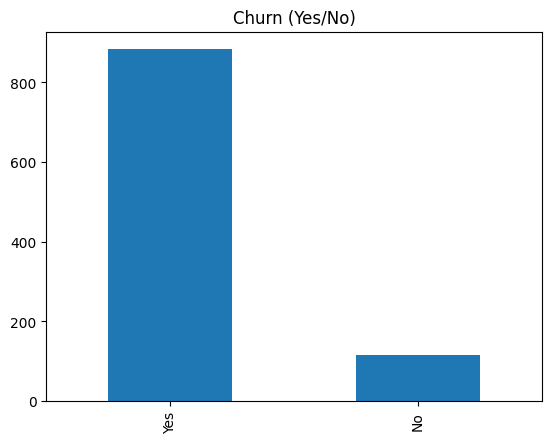

In [11]:
churn_df["Churn"].value_counts().plot(kind='bar')
plt.title("Churn (Yes/No)")
plt.xlabel("")

In [12]:
churn_df.groupby('Churn')["MonthlyCharges"].mean()

Churn
No     62.54641
Yes    75.96077
Name: MonthlyCharges, dtype: float64

In [13]:
churn_df.groupby(['Churn', 'Gender'])["MonthlyCharges"].mean()

Churn  Gender
No     Female    65.091912
       Male      59.013878
Yes    Female    74.975064
       Male      77.082518
Name: MonthlyCharges, dtype: float64

In [14]:
churn_df.groupby("Churn")["Tenure"].mean()

Churn
No     30.264957
Yes    17.476784
Name: Tenure, dtype: float64

In [15]:
churn_df.groupby("Churn")["Age"].mean()

Churn
No     43.487179
Yes    44.831257
Name: Age, dtype: float64

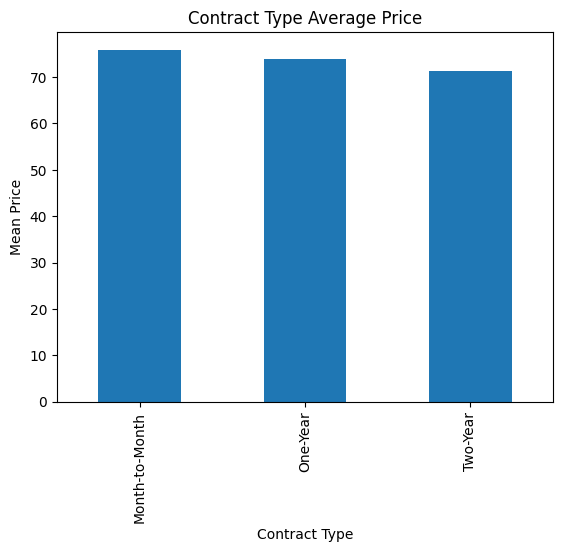

In [16]:
churn_df.groupby(["ContractType"])["MonthlyCharges"].mean().plot(kind='bar')
plt.ylabel("Mean Price")
plt.xlabel("Contract Type")
plt.title("Contract Type Average Price")
plt.show()

Text(0.5, 1.0, 'Histogram Monthly Charges')

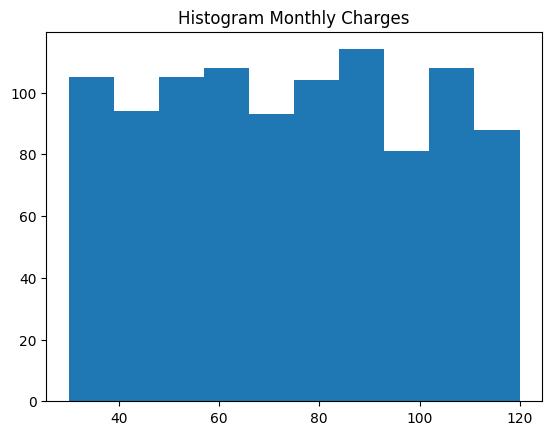

In [17]:
plt.hist(churn_df["MonthlyCharges"])
plt.title("Histogram Monthly Charges")

(array([490., 233., 127.,  64.,  36.,  30.,  13.,   2.,   4.,   1.]),
 array([  0. ,  12.2,  24.4,  36.6,  48.8,  61. ,  73.2,  85.4,  97.6,
        109.8, 122. ]),
 <BarContainer object of 10 artists>)

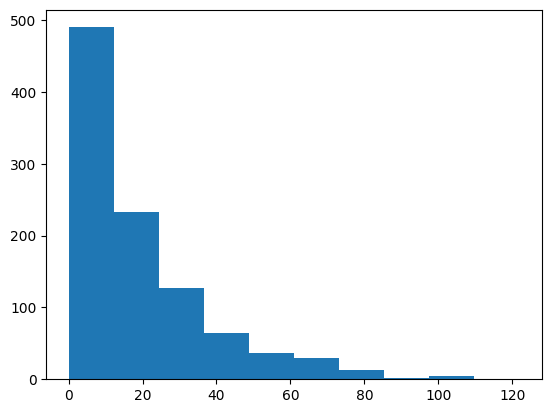

In [18]:
plt.hist(churn_df["Tenure"])

## Feature Engineering 

In [19]:
churn_df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'MonthlyCharges',
       'ContractType', 'InternetService', 'TotalCharges', 'TechSupport',
       'Churn'],
      dtype='object')

In [20]:
X = churn_df[["Age", "Gender", "Tenure", "MonthlyCharges", "TechSupport", "ContractType", "InternetService"]]
y = churn_df["Churn"].apply(lambda x: 1 if x == 'Yes' else 0)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
num_feats = ["Age", "Tenure", "MonthlyCharges"]
cat_feats_ord = ["Gender", "TechSupport"]
cat_feats_ohe = ["ContractType", "InternetService"]

In [23]:
# Шаг 1: Пайплайн для обратоки NaN в колонке InternetService
imputer_ohe_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ]
)

# Шаг 2: Трансформер остальных колонок
transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat_ord', OrdinalEncoder(), cat_feats_ord),
        ('cat_ohe', imputer_ohe_pipeline, cat_feats_ohe)
    ]
)

# Щаг 3: Основной пайплайн
lr_pipeline = Pipeline(
    steps=[
        ('preprocessor', transformer),
        ('log_reg', LogisticRegression())
    ]
)

knn_pipeline = Pipeline(
    steps=[
        ('preprocessor', transformer),
        ('knn_clf', KNeighborsClassifier())
    ]
)

svm_pipeline = Pipeline(
    steps=[
        ('preprocessor', transformer),
        ('svm_clf', SVC())
    ]
)

dt_pipeline = Pipeline(
    steps=[
        ('preprocessor', transformer),
        ('dt_clf',DecisionTreeClassifier())
    ]
)

rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', transformer),
        ('rf_clf',RandomForestClassifier())
    ]
)

In [24]:
lr_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('log_reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
y_pred = lr_pipeline.predict(X_test)

In [26]:
accuracy_score(y_test, y_pred)

0.955

In [27]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.9375,
  'recall': 0.6521739130434783,
  'f1-score': 0.7692307692307693,
  'support': 23.0},
 '1': {'precision': 0.9565217391304348,
  'recall': 0.9943502824858758,
  'f1-score': 0.9750692520775623,
  'support': 177.0},
 'accuracy': 0.955,
 'macro avg': {'precision': 0.9470108695652174,
  'recall': 0.823262097764677,
  'f1-score': 0.8721500106541658,
  'support': 200.0},
 'weighted avg': {'precision': 0.9543342391304348,
  'recall': 0.955,
  'f1-score': 0.9513978265501811,
  'support': 200.0}}

In [28]:
params_grid = {
    "knn_clf__n_neighbors": [3, 5, 7, 9],
    "knn_clf__weights": ['uniform', 'distance']
}

In [29]:
grid_knn = GridSearchCV(
    knn_pipeline,
    param_grid=params_grid,
    cv=5
)

In [30]:
grid_knn.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'knn_clf__n_neighbors': [3, 5, ...], 'knn_clf__weights': ['uniform', 'distance']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat_ord', ...), ...]"


In [31]:
grid_knn.best_params_

{'knn_clf__n_neighbors': 5, 'knn_clf__weights': 'uniform'}

In [32]:
y_pred = grid_knn.predict(X_test)

In [33]:
accuracy_score(y_test, y_pred)

0.945

In [34]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.9285714285714286,
  'recall': 0.5652173913043478,
  'f1-score': 0.7027027027027027,
  'support': 23.0},
 '1': {'precision': 0.946236559139785,
  'recall': 0.9943502824858758,
  'f1-score': 0.9696969696969697,
  'support': 177.0},
 'accuracy': 0.945,
 'macro avg': {'precision': 0.9374039938556068,
  'recall': 0.7797838368951118,
  'f1-score': 0.8361998361998362,
  'support': 200.0},
 'weighted avg': {'precision': 0.944205069124424,
  'recall': 0.945,
  'f1-score': 0.938992628992629,
  'support': 200.0}}

In [35]:
params_grid_svm = {
    "svm_clf__C": [0.01, 0.1, 0.5, 1],
    "svm_clf__kernel": ["linear", "rbf", "poly"]
}

In [36]:
svm_grid = GridSearchCV(
    svm_pipeline,
    param_grid=params_grid_svm,
    cv=5
)

In [37]:
svm_grid.fit(X_train, y_train)

,estimator,"Pipeline(step...clf', SVC())])"
,param_grid,"{'svm_clf__C': [0.01, 0.1, ...], 'svm_clf__kernel': ['linear', 'rbf', ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat_ord', ...), ...]"


In [38]:
y_pred = svm_grid.predict(X_test)

In [39]:
svm_grid.best_params_

{'svm_clf__C': 1, 'svm_clf__kernel': 'poly'}

In [40]:
accuracy_score(y_test, y_pred)

0.965

In [41]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 1.0,
  'recall': 0.6956521739130435,
  'f1-score': 0.8205128205128205,
  'support': 23.0},
 '1': {'precision': 0.9619565217391305,
  'recall': 1.0,
  'f1-score': 0.9806094182825484,
  'support': 177.0},
 'accuracy': 0.965,
 'macro avg': {'precision': 0.9809782608695652,
  'recall': 0.8478260869565217,
  'f1-score': 0.9005611193976845,
  'support': 200.0},
 'weighted avg': {'precision': 0.9663315217391305,
  'recall': 0.965,
  'f1-score': 0.9621983095390297,
  'support': 200.0}}

In [42]:
params_grid_dt = {
    "dt_clf__criterion": ["gini", "entropy"],
    "dt_clf__splitter": ["best", "random"],
    "dt_clf__max_depth": [None, 10, 20, 30],
    "dt_clf__min_samples_split": [2, 5, 10],
    "dt_clf__min_samples_leaf": [1, 2, 4]
}

In [43]:
dt_grid = GridSearchCV(
    dt_pipeline,
    param_grid=params_grid_dt,
    cv=5
)

In [44]:
dt_grid.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'dt_clf__criterion': ['gini', 'entropy'], 'dt_clf__max_depth': [None, 10, ...], 'dt_clf__min_samples_leaf': [1, 2, ...], 'dt_clf__min_samples_split': [2, 5, ...], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat_ord', ...), ...]"


In [45]:
dt_grid.best_params_

{'dt_clf__criterion': 'gini',
 'dt_clf__max_depth': None,
 'dt_clf__min_samples_leaf': 1,
 'dt_clf__min_samples_split': 2,
 'dt_clf__splitter': 'best'}

In [46]:
y_pred = dt_grid.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred)

1.0

In [48]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 177.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 200.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 200.0}}

In [49]:
params_grid_rf = {
    "rf_clf__n_estimators": [32, 64, 128, 256],
    "rf_clf__max_features": [2, 3, 6],
    "rf_clf__bootstrap": [True, False]
}

In [50]:
rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=params_grid_rf,
    cv=5
)

In [51]:
rf_grid.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'rf_clf__bootstrap': [True, False], 'rf_clf__max_features': [2, 3, ...], 'rf_clf__n_estimators': [32, 64, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat_ord', ...), ...]"


In [52]:
rf_grid.best_params_

{'rf_clf__bootstrap': True,
 'rf_clf__max_features': 6,
 'rf_clf__n_estimators': 32}

In [53]:
y_pred = rf_grid.predict(X_test)

In [54]:
accuracy_score(y_test, y_pred)

1.0

In [55]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 177.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 200.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 200.0}}

In [56]:
best_model = rf_grid.best_estimator_

In [57]:
joblib.dump(best_model, "best_model.pkl")

['best_model.pkl']